In [5]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import pickle
import warnings
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

# Ensure nltk punkt is downloaded
nltk.download('punkt')

# Suppress warnings about CPU count
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Set this to the number of cores you want to use
warnings.filterwarnings("ignore", category=UserWarning, module="joblib.externals.loky")

# Step 1: Load the dataset
data = pd.read_csv("Coursera.csv")

# Step 2: Preprocess the data

# Tokenization function
def tokenize(text):
    return word_tokenize(text)

# Tokenizing 'Course Name', 'Course Description', and 'Skills'
data['course_name_tokens'] = data['Course Name'].astype(str).apply(lambda x: tokenize(x.lower()))
data['description_tokens'] = data['Course Description'].astype(str).apply(lambda x: tokenize(x.lower()))
data['skills_tokens'] = data['Skills'].astype(str).apply(lambda x: tokenize(x.lower()))

# Clean 'Skills' column - remove commas and convert to lowercase
data['tags'] = data['skills_tokens'].apply(lambda x: ' '.join(x))

# Clean 'Course Name' column - remove commas, special characters, and convert to lowercase
data['course_name_tokens'] = data['course_name_tokens'].apply(lambda x: [word for word in x if word.isalnum()])
data['description_tokens'] = data['description_tokens'].apply(lambda x: [word for word in x if word.isalnum()])

# Join the tokens back into a string for vectorization
data['tags'] = data['course_name_tokens'].apply(lambda x: ' '.join(x)) + ' ' + data['description_tokens'].apply(lambda x: ' '.join(x)) + ' ' + data['skills_tokens'].apply(lambda x: ' '.join(x))

# Rename 'Course Name' to 'course_name' for consistency
data.rename(columns={'Course Name': 'course_name'}, inplace=True)

# Remove duplicates based on course name
data.drop_duplicates(subset=['course_name'], inplace=True)

# Step 3: Create vectors for cosine similarity
cv = CountVectorizer(max_features=5000, stop_words='english')  # Initialize vectorizer
vectors = cv.fit_transform(data['tags']).toarray()  # Convert tags into vectors

# Step 4: Calculate cosine similarity
similarity = cosine_similarity(vectors)  # Compute similarity matrix
pickle.dump(similarity, open('similarity.pkl', 'wb'))  # Save similarity matrix

# Step 5: Perform KMeans clustering
kmeans_model = KMeans(n_clusters=5, random_state=42)  # Initialize KMeans with 5 clusters
data['Cluster'] = kmeans_model.fit_predict(vectors)  # Add cluster assignments to the dataset
pickle.dump(kmeans_model, open('courses.pkl', 'wb'))  # Save the clustering model

# Step 6: Save the cleaned and clustered data to an Excel file
output_file = "Cleaned_Coursera_Data.xlsx"
data.to_excel(output_file, index=False)  # Save to Excel
print(f"Cleaned and clustered data saved to {output_file}.")

# Step 7: Save course list for future use
pickle.dump(data.to_dict(), open('course_list.pkl', 'wb'))
print("Course list and similarity data have been saved.")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmedrahmo1388/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cleaned and clustered data saved to Cleaned_Coursera_Data.xlsx.
Course list and similarity data have been saved.


In [6]:
import os
import pandas as pd
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

# Download necessary NLTK data
nltk.download('punkt')

# Initialize Porter Stemmer
stemmer = PorterStemmer()

def preprocess_text(text):
    """Tokenize and stem the input text."""
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token.isalnum()]  # Stem and remove non-alphanumeric tokens
    return ' '.join(stemmed_tokens)

# Example dataset (replace with actual data loading)
data = pd.read_csv("Coursera.csv")

# Preprocess relevant columns
data['Skills'] = data['Skills'].fillna('No Skills Listed').apply(preprocess_text)
data['Course Name'] = data['Course Name'].fillna('No Course Name Provided').apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmedrahmo1388/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


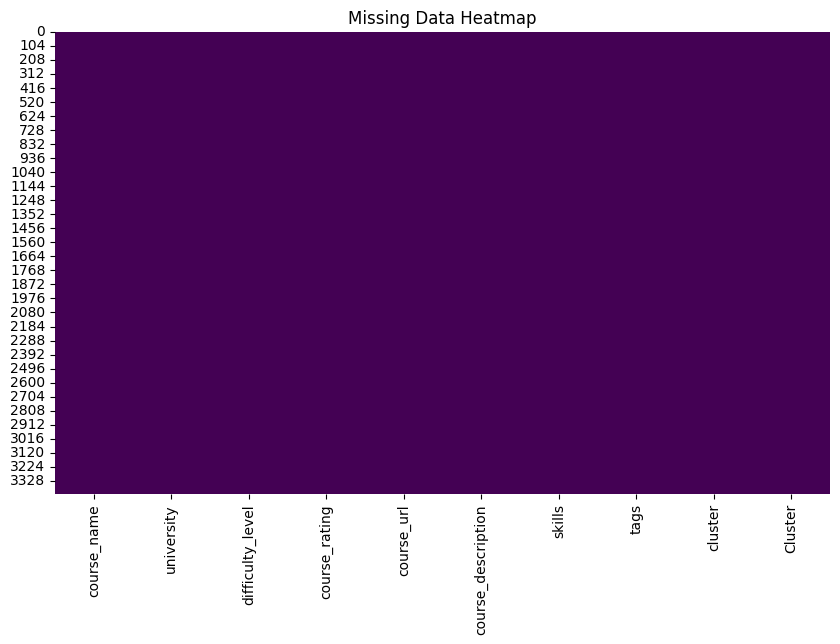

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans

# Load your cleaned dataset (assuming it's already cleaned and saved as 'Cleaned_Coursera_Data.xlsx')
data = pd.read_excel("Cleaned.xlsx")

# Ensure the data is ready and doesn't have any missing 'Cluster' column
if 'Cluster' not in data.columns:
    # Apply KMeans clustering
    # Example: We'll use numeric columns for clustering, make sure to adjust based on your data
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        kmeans = KMeans(n_clusters=5, random_state=42)
        data['Cluster'] = kmeans.fit_predict(data[numeric_columns])

# Step 1: Missing Data Visualization - Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# Step 2: Distribution Plots for Numeric Data (If applicable)
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()


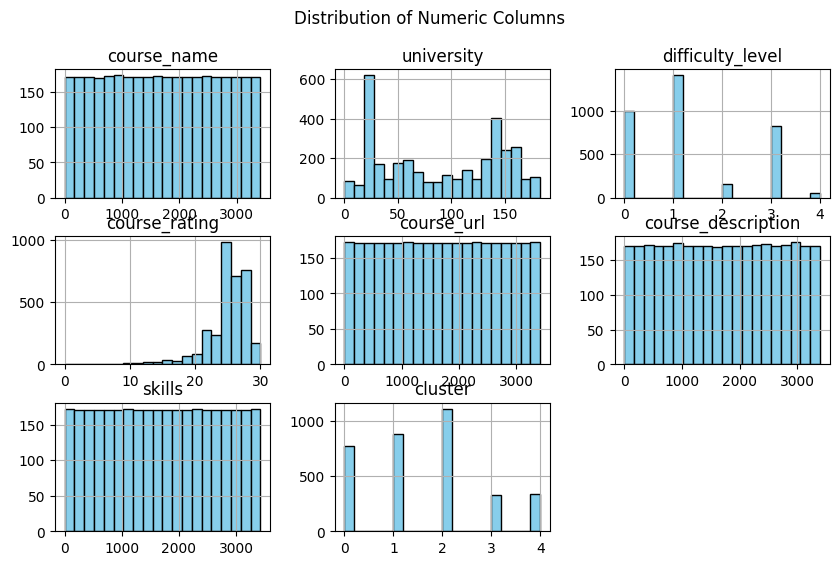

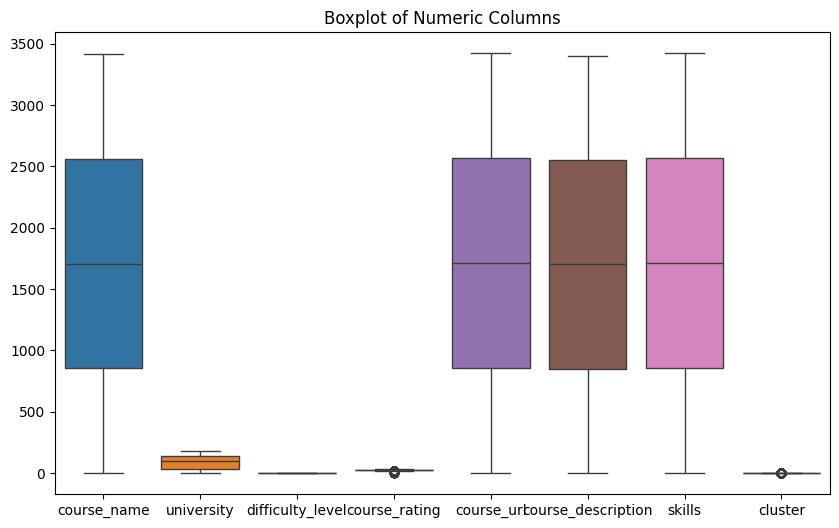

In [8]:
# Step 2: Distribution Plots for Numeric Data (If applicable)
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

if numeric_columns:
    # Histogram for Numeric Data
    data[numeric_columns].hist(figsize=(10, 6), bins=20, color='skyblue', edgecolor='black')
    plt.suptitle('Distribution of Numeric Columns')
    plt.show()

    # Boxplot for Numeric Data
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data[numeric_columns])
    plt.title('Boxplot of Numeric Columns')
    plt.show()

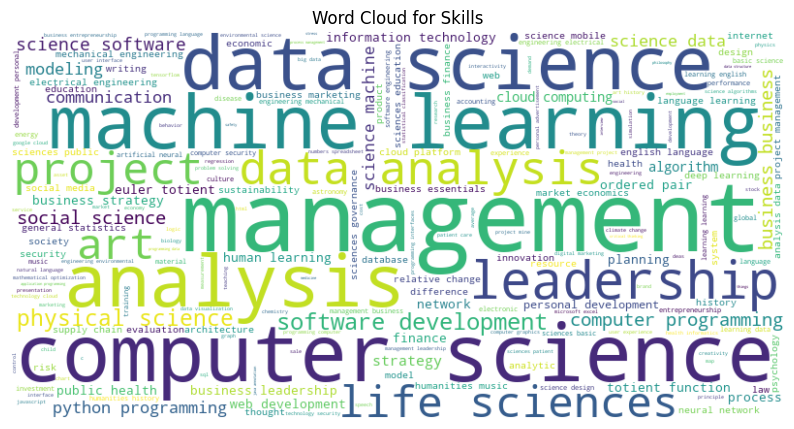

In [9]:
# Step 3: Word Cloud for 'tags' (Skills column)
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['tags']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Skills')
plt.show()


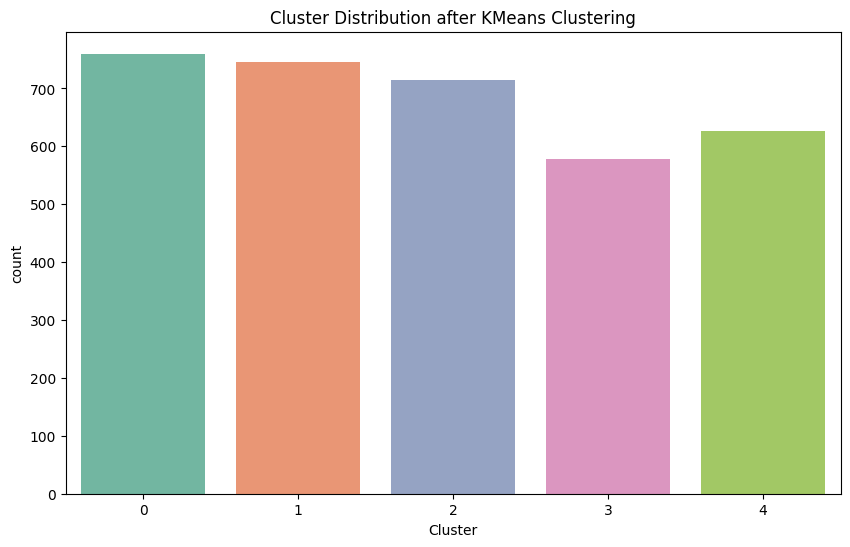

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Countplot for 'Cluster' (After KMeans clustering)
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=data, hue='Cluster', palette='Set2', legend=False)
plt.title('Cluster Distribution after KMeans Clustering')
plt.show()


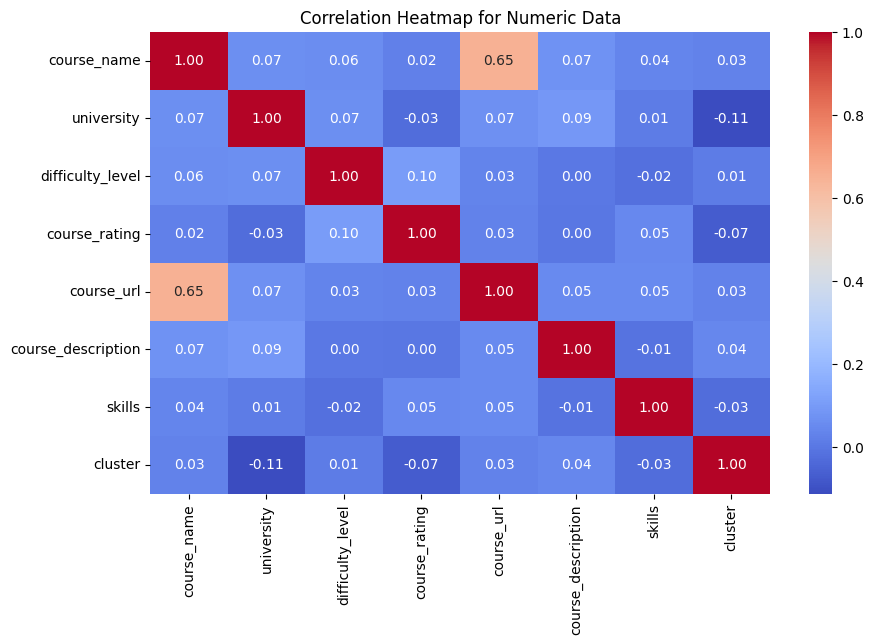

In [11]:

# Step 5: Correlation Heatmap for Numeric Columns (If available)
if numeric_columns:
    plt.figure(figsize=(10, 6))
    correlation_matrix = data[numeric_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap for Numeric Data')
    plt.show()


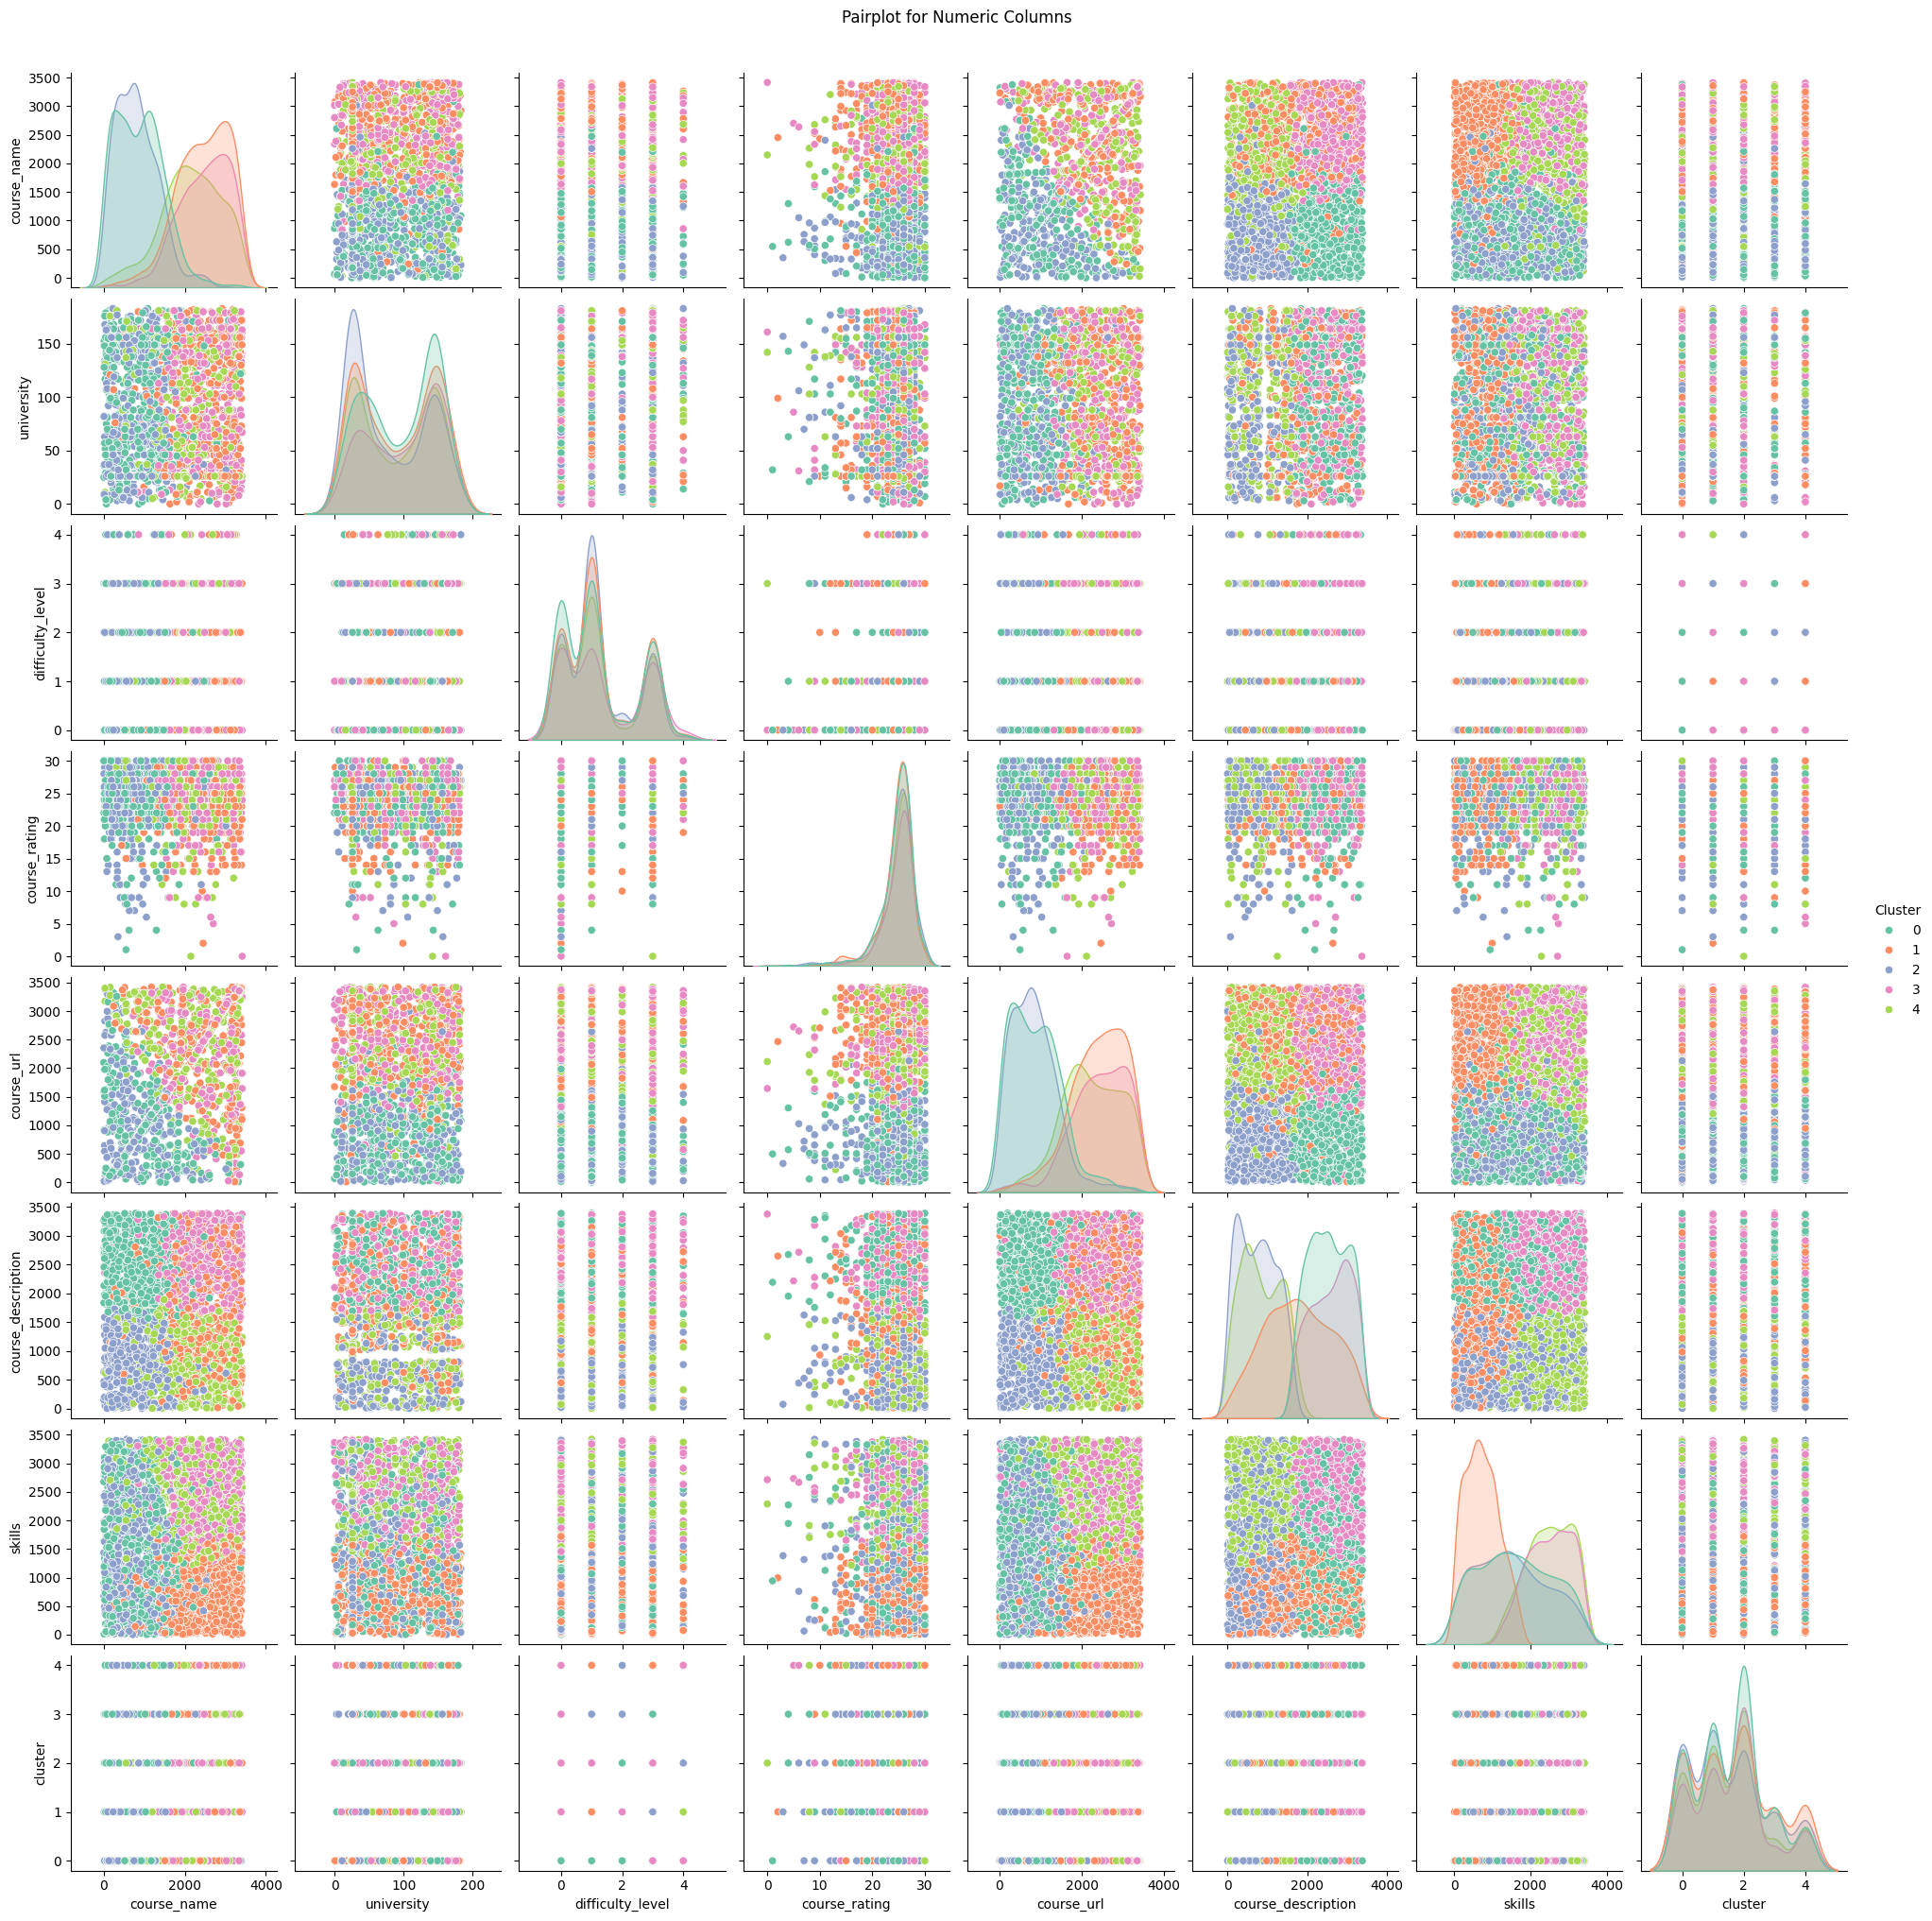

In [12]:
# Step 6: Pairplot for Numeric Data (If available)
if numeric_columns:
    # Ensure that the 'Cluster' column is included for hue
    if 'Cluster' in data.columns:
        sns.pairplot(data[numeric_columns + ['Cluster']], hue='Cluster', palette='Set2')
        plt.suptitle('Pairplot for Numeric Columns', y=1.02)
        plt.show()
